In [1]:
import numpy as np, pandas as pd, requests as r, io, warnings
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as BS
warnings.filterwarnings('ignore')

In [7]:
# Reqest the main page of the website

main_url='https://community.dur.ac.uk/hubert.shum/comp42315_resit'
main_page=r.get(main_url)
soup0=BS(main_page.content,'html.parser')

In [8]:
# Question 1:Please design and implement the solution to crawl all the unique URLs for the detailed publication pages
# Open the page under each topic
main_navigator=soup0.find('div', class_='navigator')
link_list=[]
#Because the first page is at the second anchor element
first_publication=main_url+'/'+main_navigator.find_all('a')[1]['href']
publication_page=r.get(first_publication)
soup1=BS(publication_page.content,'html.parser')
links=soup1.find('p', class_='TextOption')
for link in links.find_all('a', href=True):
    link_list.append(main_url+'/'+link['href'])

#Add the first page at the first position of the list
link_list.insert(0,first_publication)

15

In [9]:
# Because I want to analyse the relationship betwwen topics and author's name, I have to create lists for storing them with duplicates

all_link=[]
topics=[]
# Because the each topic title hapes like 'XXXXX Research Publications | COMP42315 Assignment Site for Crawling' while the length from behind is fixed

print(-len('Research Publications | COMP42315 Assignment Site for Crawling'))

for link in link_list:
    link_page=r.get(link)
    soup=BS(link_page.content,'html.parser')
    topic=soup.find('title').text[:-63:1]

    pulication_divs=soup.find_all('div',class_='w3-container w3-cell w3-mobile w3-cell-middle')
# Find the partical link information and store them into the list, which is the third position of span
    for pulication_div in pulication_divs:#
# Concat the partical link information with the main link to build new links that could be visited
        pulication_span=main_url+'/'+pulication_div.find_all('span',class_='TextSmallDefault')[2].find('a')['href']
        all_link.append(pulication_span)
        topics.append(topic)

children_page_list=pd.DataFrame({'children':all_link})
father_page_list=pd.DataFrame({'father':topics})
pages=pd.merge(children_page_list,father_page_list,left_index=True,right_index=True,how='outer')
unique_index=pages.drop_duplicates(subset=['children'], keep='first',inplace=False).index
duplication=pages.drop(pages.index[[unique_index]])
print(len(duplication))
pages.drop_duplicates(subset=['children'], keep='first', inplace=True)
pages.reset_index(drop=True, inplace=True)

# Find the duplicated publications which have multiple topics
first_combination=pd.merge(pages,duplication,on='children',how='outer')
first_duplicate_bool = first_combination.duplicated(subset=['children'], keep='first')
find_duplicate = first_combination.loc[first_duplicate_bool == True]
print(find_duplicate)

#Therefore, only one publication has three topics that I have to drop the third duplicated topic first and then add a new coloumns
new_pages=first_combination.drop([12])
new_pages['3rd topic']=None
new_pages.iloc[11,3]='Topology Analysis'
new_pages.reset_index(drop=True, inplace=True)

-62
42
                                             children             father_x  \
12  https://community.dur.ac.uk/hubert.shum/comp42...  Character Animation   

             father_y  
12  Topology Analysis  


In [14]:
pages

,children,father
0,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation
1,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation
2,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation
3,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation
4,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation
...,...,...
105,https://community.dur.ac.uk/hubert.shum/comp42...,Machine Learning
106,https://community.dur.ac.uk/hubert.shum/comp42...,Machine Learning
107,https://community.dur.ac.uk/hubert.shum/comp42...,Machine Learning
108,https://community.dur.ac.uk/hubert.shum/comp42...,Machine Learning


In [10]:
# Qustion 2: Please design and implement the solution to crawl all the text-based information of each publication from the website, to convert such information into a suitable data format, and to store it in a data file
# The text-based information includes:
# titles,author_names,author_name_positions,abstracts,journal_names,citations,impact_factors,paper_links,video_links, DOI_links, Youtube_links
titles=[]
author_names=[]
abstracts=[]
journal_names=[]
citations=[]
impact_factors=[]
paper_links=[]
DOI_links=[]
Youtube_links=[]

In [11]:
for link in new_pages.children:
    soup=BS(r.get(link).content,'html.parser')
    
    title=soup.find('h1').text
    titles.append(title)
    
    raw_author_name=soup.find_all('p',class_='TextSmallDefault')[2].text
    group_author_name=raw_author_name[:raw_author_name.find(', "')].replace(' and',',')
    author_names.append(group_author_name)

    abstract=soup.find_all('div',attrs={'style':'margin-left: var(--size-marginleft)'})[0].find('p').text
    abstracts.append(abstract)
    
    journal_name=soup.find('em').text[6:]
    journal_names.append(journal_name)
    
    #Becuase the requests of both impact factor and citation look like this 'Impact Factor: XXX# Citation: XXX##' 
    pre_processing_imf_cit=soup.find('span', class_='TextHighlightDefault').text
    try:
        if len(pre_processing_imf_cit[pre_processing_imf_cit.find('r: ')+3:pre_processing_imf_cit.find('#')])==5:
            impact_factor=pre_processing_imf_cit[pre_processing_imf_cit.find('r: ')+3:pre_processing_imf_cit.find('#')]
        else:
            impact_factor=None
    except:
        pass
    impact_factors.append(impact_factor)

    try:
        if (len(pre_processing_imf_cit[pre_processing_imf_cit.find('n: ')+3:pre_processing_imf_cit.find('## ')])<=3) & (len(pre_processing_imf_cit[pre_processing_imf_cit.find('n: ')+3:pre_processing_imf_cit.find('## ')])>0):
            citation=pre_processing_imf_cit[pre_processing_imf_cit.find('n: ')+3:pre_processing_imf_cit.find('## ')]
        else:
            citation=None
    except:
        citation=None
    citations.append(citation)

    try:
        paper_link=soup.find_all('div',attrs={'style':'margin-left: var(--size-marginleft)'})[2].find('a')['href']
    except:
        paper_link=None
    paper_links.append(paper_link)

    try:
        DOI_link=soup.find_all('div',attrs={'style':'margin-left: var(--size-marginleft)'})[2].find_all('div', class_='ImgThumbnailDiv')[2].find('a')['href']
    except:
        DOI_link=None
    DOI_links.append(DOI_link)
    try:
        Youtube_link=soup.find('iframe',class_='youtube-player')['src']
    except:
        Youtube_link=None
    Youtube_links.append(Youtube_link)

author_names_df = pd.DataFrame([each_name.split(", ") for each_name in author_names])

AttributeError: 'NoneType' object has no attribute 'text'

In [ ]:
author_names_df=author_names_df.rename(columns={0:'lst author',1:'2nd author',2:'3rd author',
                                                3:'4th author',4:'5th author',5:'6th author',
                                                6:'7th author'})                                             
new_pages=new_pages.rename(columns={'children':'publication page','father_x':'1st topic','father_y':'2nd topic','3rd topic':'3rd topic'})

title=pd.DataFrame({'title':titles})
abstract=pd.DataFrame({'abstract':abstracts})
journal=pd.DataFrame({'journal':journal_names})
impact_factor=pd.DataFrame({'impact factor':impact_factors})
citation=pd.DataFrame({'citation':citations})
paper_link=pd.DataFrame({'paper link':paper_links})
DOI_link=pd.DataFrame({'doi link':DOI_links})
Youtube_link=pd.DataFrame({'youtube link':Youtube_links})

all_information=pd.concat([new_pages,author_names_df,title,abstract,journal,impact_factor,citation,paper_link,DOI_link,Youtube_link],axis=1)

all_information['2nd topic'] = all_information['2nd topic'].fillna(value=0)
all_information['2nd topic'][all_information['2nd topic']==0]=None

all_information.to_csv('Assignment Data.csv',sep=' ')

In [ ]:
all_information

,publication page,1st topic,2nd topic,3rd topic,lst author,2nd author,3rd author,4th author,5th author,6th author,7th author,title,abstract,journal,impact factor,citation,paper link,doi link,youtube link
0,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation,None,None,He Wang,Edmond S. L. Ho,Hubert P. H. Shum,Zhanxing Zhu,None,None,None,Spatio-temporal Manifold Learning for Human Mo...,Data-driven modeling of human motions is ubiqu...,IEEE Transactions on Visualization and Compute...,4.579,74,publications/tvcg2021deeplearning/files/tvcg20...,http://doi.org/10.1109/TVCG.2019.2936810,https://www.youtube.com/embed/1eZxWkLj1lg
1,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation,None,None,Qianhui Men,Edmond S. L. Ho,Hubert P. H. Shum,Howard Leung,None,None,None,A Quadruple Diffusion Convolutional Recurrent ...,Recurrent neural network (RNN) has become popu...,IEEE Transactions on Circuits and Systems for ...,4.685,13,publications/tcsvt2021prediction/files/tcsvt20...,publications/tcsvt2021prediction/files/tcsvt20...,https://www.youtube.com/embed/qyE2PuAXXOA
2,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation,Interaction Modelling,None,Qianhui Men,Hubert P. H. Shum,Edmond S. L. Ho,Howard Leung,None,None,None,GAN-based Reactive Motion Synthesis with Class...,Creating realistic characters that can react t...,Computers and Graphics (C&G),1.936,None,publications/cag2021reactive/files/cag2021reac...,http://doi.org/10.1016/j.cag.2021.09.014,https://www.youtube.com/embed/Zhmup_GM4zk
3,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation,Face Modelling,None,Jacky C. P. Chan,Hubert P. H. Shum,He Wang,Li Yi,Wei Wei,Edmond S. L. Ho,None,A Generic Framework for Editing and Synthesizi...,Emotion is considered to be a core element in ...,Computer Animation and Virtual Worlds (CAVW),1.020,6,publications/cavw2019emotion/files/cavw2019emo...,http://doi.org/10.1002/cav.1871,https://www.youtube.com/embed/wbcrC2K4ghc
4,https://community.dur.ac.uk/hubert.shum/comp42...,Character Animation,None,None,Naoya Iwamoto,Hubert P. H. Shum,Wakana Asahina,Shigeo Morishima,None,None,None,Automatic Sign Dance Synthesis from Gesture-ba...,Automatic dance synthesis has become more and ...,Proceedings of the 2019 International Conferen...,None,None,publications/mig2019dance/files/mig2019dance.pdf,http://doi.org/10.1145/3359566.3360069,https://www.youtube.com/embed/D6D1x0ufZis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,https://community.dur.ac.uk/hubert.shum/comp42...,Machine Learning,None,None,Lining Zhang,Hubert P. H. Shum,Ling Shao,None,None,None,None,Manifold Regularized Experimental Design for A...,Various machine learning and data mining tasks...,IEEE Transactions on Image Processing (TIP),None,11,publications/tip2017manifold/files/tip2017mani...,None,None
106,https://community.dur.ac.uk/hubert.shum/comp42...,Machine Learning,None,None,Lining Zhang,Hubert P. H. Shum,Ling Shao,None,None,None,None,Discriminative Semantic Subspace Analysis for ...,Content-based image retrieval (CBIR) has attra...,IEEE Transactions on Image Processing (TIP),None,29,publications/tip2016feedback/files/tip2016feed...,None,None
107,https://community.dur.ac.uk/hubert.shum/comp42...,Machine Learning,None,None,Jie Li,Hubert P. H. Shum,Xin Fu,Graham Sexton,Longzhi Yang,None,None,Experience-based Rule Base Generation and Adap...,Fuzzy modeling has been widely and successfull...,Proceedings of the 2016 IEEE International Con...,None,14,publications/fuzz2016experience/files/fuzz2016...,None,None
108,https://community.dur.ac.uk/hubert.shum/comp42...,Machine Learning,None,None,Yao Tan,Jie Li,Martin Wonders,Fei Chao,Hubert P. H. Shum,Longzhi Yang,None,Towards Sparse Rule Base Generation for Fuzzy ...,Fuzzy inference systems have been successfully...,Proceedings of the 2016 IEEE International Con...,None,14,publications/fuzz2016sparse/files/fuzz2016spar...,None,None


In [ ]:
#Question 3 Please design and implement a solution to find out the 100 most popular words used for the title and the abstract of the publications. You should define what a “word” means under your design
import nltk, math
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from collections import Counter
from nltk.corpus import stopwords as sw
from nltk.util import ngrams as ng
from nltk.tokenize import word_tokenize as tk
from nltk.stem import WordNetLemmatizer as wn
# I have set the popularity of words as the frequency of words or double word groups
# 50 ranks for titles, and 50 ranks for abstracts
# 25 ranks inside titles will analyse the double word groups while the rest will focus on the single words, same as for the abstracts

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ky002\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ky002\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ky002\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ky002\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Combine each title and abstract into a separate list since the importance of two lists are different
title_content=[each_title for each_title in all_information.title]
abstract_content=[each_abstract for each_abstract in all_information.abstract]

# To have a view about the first 50 frequency words in both title and abstract
counter_title_50 =Counter(' '.join(title_content).split()).most_common(50)
print(counter_title_50)

counter_abstract_50 =Counter(' '.join(abstract_content).split()).most_common(50)
print(counter_abstract_50)

[('for', 45), ('with', 33), ('and', 18), ('A', 16), ('in', 16), ('Motion', 15), ('of', 14), ('Learning', 13), ('Human', 13), ('Kinect', 12), ('using', 11), ('a', 10), ('3D', 8), ('on', 8), ('Reconstruction', 8), ('based', 7), ('Control', 7), ('Deep', 7), ('Recognition', 7), ('Network', 6), ('Prediction', 6), ('Data', 6), ('from', 6), ('Depth', 6), ('Interactions', 6), ('Assessment', 6), ('Shape', 6), ('Using', 6), ('Rule', 6), ('Synthesis', 5), ('Automatic', 5), ('Character', 5), ('Simulating', 5), ('Pose', 5), ('Graph', 5), ('Reality', 5), ('via', 4), ('Framework', 4), ('Animation', 4), ('System', 4), ('Generation', 4), ('Analysis', 4), ('an', 4), ('Boxing', 4), ('Environment', 4), ('Posture', 4), ('Action', 4), ('Detection', 4), ('Sparse', 4), ('Fuzzy', 4)]
[('the', 1171), ('of', 634), ('a', 590), ('to', 567), ('and', 515), ('in', 326), ('is', 284), ('that', 218), ('with', 215), ('as', 191), ('for', 185), ('we', 169), ('can', 134), ('such', 132), ('motion', 121), ('are', 120), ('The'

In [ ]:
# A forbidden word dictionary for meaningless words
exclude_words=sw.words('english')
exclude_words=exclude_words+[',','.','/','%',';',':','('')',' ','?','also','using','used','propose','show','new','via','(',')','however','based','proposed']


#combine the element in two lists together and tokenise them into separate words
def list_to_token(list):
    roken_list = []
    for text in list:
        roken_list.append(tk(text))
    return roken_list

title_doc = list_to_token(title_content)
abstract_doc=list_to_token(abstract_content)

def combine_each_chunk(data):
    each_chunk=[]
    for each_record in data:
        for dic in each_record:
            each_chunk.append(dic)
    return each_chunk
    
each_title_doc=combine_each_chunk(title_doc)
each_abstract_doc=combine_each_chunk(abstract_doc)

#Exclude the meaningless words from the two lists

def exclude_meaningless_word(unquie_words):
    select_words=[]
    for unquie_word in unquie_words:
        if unquie_word.lower() not in exclude_words:
            select_word=select_words.append(unquie_word)
    return select_words

pre_processing_title=[unit.lower() for unit in exclude_meaningless_word(each_title_doc)]
pre_processing_abstract=[unit.lower() for unit in exclude_meaningless_word(each_abstract_doc)]

# Join the word debrics togther for dural-word anaylsis
str=' '
join_title_debrics=str.join(pre_processing_title)
join_abstract_debrics=str.join(pre_processing_title)
# Function to generate n-grams from sentences when the n equals 2.
def extract_nearest_words(data, dim):
    n_grams = ng(tk(data), dim)
    return [ ' '.join(grams) for grams in n_grams]

double_title_list=extract_nearest_words(str.join(pre_processing_title),2)
double_title_analysis=Counter(double_title_list).most_common(25)
print(double_title_analysis)

double_abstract_list=extract_nearest_words(str.join(pre_processing_abstract),2)
double_abstract_analysis=Counter(double_abstract_list).most_common(25)
print(double_abstract_analysis)

most_25_title_common_words=[word for word, word_count in double_title_analysis]
most_25_abstract_common_words=[word for word, word_count in double_abstract_analysis]

# the similarity of two selected lists
similar_words=[word for word in most_25_title_common_words if word in most_25_abstract_common_words]
print('similar words :', similar_words)
print('similarity ratio :', len(similar_words)/len(most_25_title_common_words))

[('deep learning', 5), ('shape reconstruction', 4), ('action recognition', 4), ('human motion', 3), ('microsoft kinect', 3), ('simulating interactions', 3), ('3d car', 3), ('car shape', 3), ('posture reconstruction', 3), ('augmented reality', 3), ('sparse rule', 3), ('rule base', 3), ('base generation', 3), ('recurrent network', 2), ('relative emotion', 2), ('emotion strength', 2), ('strength automatic', 2), ('sign language', 2), ('model real-time', 2), ('generating realistic', 2), ('realistic fighting', 2), ('fighting scenes', 2), ('scenes game', 2), ('game tree', 2), ('channel attention', 2)]
[('experimental results', 30), ('motion capture', 17), ('computer games', 15), ('deep learning', 14), ('rule base', 14), ('neural network', 12), ('human motion', 12), ('fuzzy rule', 11), ('real-time applications', 10), ('microsoft kinect', 10), ('hand pose', 10), ('rule bases', 10), ('body parts', 9), ('paper method', 9), ('capture data', 9), ('machine learning', 8), ('fuzzy inference', 8), ('le

In [ ]:
# Find the words' frequency from the above separate-word list
# lemmatise all the seperate words inside the list
lemmatizer = wn()
processed_title=[lemmatizer.lemmatize(word) for word in pre_processing_title]
processed_abstract=[lemmatizer.lemmatize(word) for word in pre_processing_abstract]

single_title_analysis=Counter(processed_title).most_common(25)
single_abstract_analysis=Counter(processed_abstract).most_common(25)
_25_title_common_words=[word.lower() for word, word_count in single_title_analysis]
_25_abstract_common_words=[word.lower() for word, word_count in single_abstract_analysis]

# the similarity of two selected lists
similar_words=[word for word in _25_title_common_words if word in _25_abstract_common_words]
print('similar words :', similar_words)
print('similarity ratio :', len(similar_words)/len(most_25_title_common_words))

top_25_single_double_words=pd.DataFrame({'Single Word in Title':_25_title_common_words,'Double Words in Title':most_25_title_common_words,
                                         'Single Word in Abstract':_25_abstract_common_words,'Double Words in Abstract':most_25_abstract_common_words})
top_25_single_double_words

similar words : ['motion', 'human', 'learning', 'interaction', 'data', 'control', 'character', 'environment', 'feature']
similarity ratio : 0.36


,Single Word in Title,Double Words in Title,Single Word in Abstract,Double Words in Abstract
0,motion,deep learning,motion,experimental results
1,human,shape reconstruction,method,motion capture
2,learning,action recognition,system,computer games
3,kinect,human motion,feature,deep learning
4,interaction,microsoft kinect,result,rule base
5,3d,simulating interactions,data,neural network
6,reconstruction,3d car,character,human motion
7,network,car shape,paper,fuzzy rule
8,data,posture reconstruction,application,real-time applications
9,control,augmented reality,human,microsoft kinect


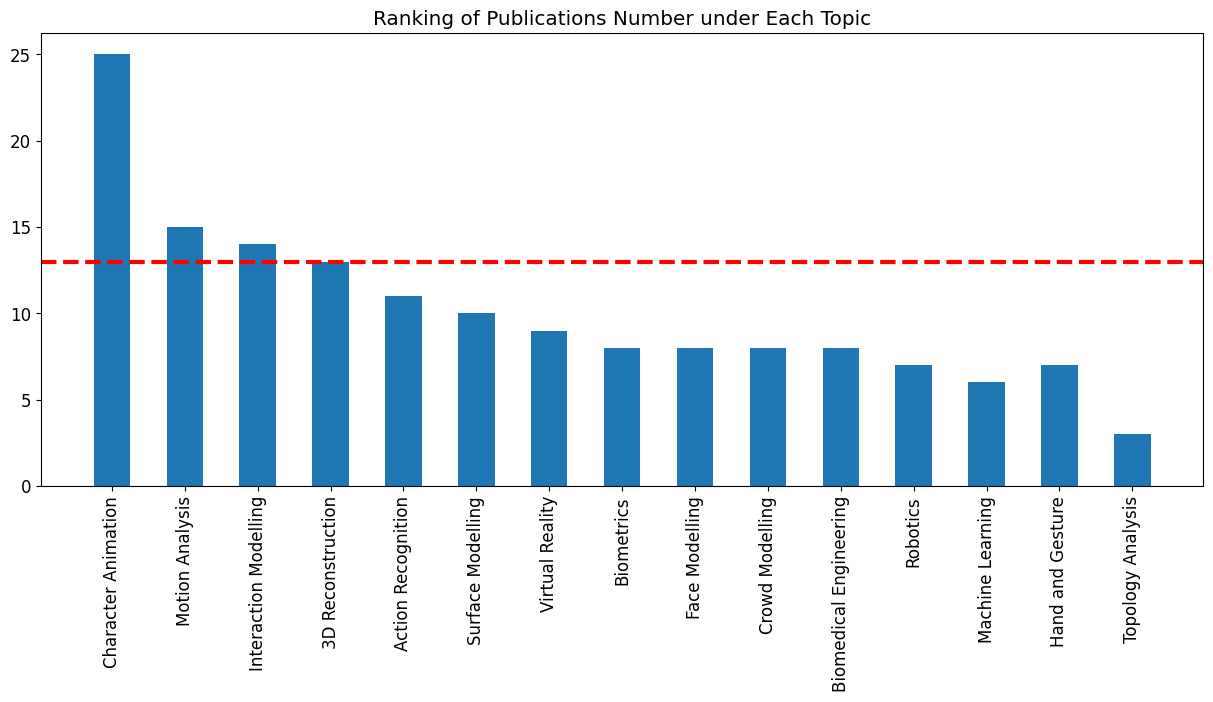

In [ ]:
#Question 4 Please design and implement the solution to use data analysis and visualization for analysing which authors collaborate (or appear) as co-authors in the publications.

# Select to top five topics with most publications
columns_names=all_information['1st topic'].drop_duplicates(keep='first', inplace=False).values.tolist()
columns_names.append('Hand and Gesture')
columns_names.append('Topology Analysis')

columns_values=[]
def each_coloumns():
    for cn in columns_names:
        new_colowns=all_information[(all_information['1st topic']==cn) | (all_information['2nd topic']==cn)|(all_information['3rd topic']==cn)]
        columns_values.append(len(new_colowns))

each_coloumns()
plt.figure(figsize=(15, 6), dpi=100)
plt.rcParams['font.size'] = '12' 
plt.xticks(rotation='vertical')
plt.title('Ranking of Publications Number under Each Topic')
plt.bar(columns_names, columns_values, width=0.5,tick_label=columns_names)
plt.axhline(y=13,linewidth=3, ls='--', color='r')
plt.savefig("Ranking of Publications Number under Each Topic.png")
plt.show()

In [ ]:
top_five_selected_lists=[]
for index, value in enumerate(columns_values):
    if value>13:
        top_five_selected_lists.append(columns_names[index])

def selected_coloumns(five_lists):
    five_lists_lower=five_lists.lower()
    five_lists_lower=all_information[(all_information['1st topic']==five_lists) | (all_information['2nd topic']==five_lists)].iloc[:,4:11]
    name_list=[]
    for columns in five_lists_lower:
        for names in five_lists_lower[columns]:
            if names!=None:
                name_list.append(names)
    #only need the top three authors
    return Counter(name_list).most_common(3)

important_author_name=[selected_coloumns(item) for item in top_five_selected_lists]
print(important_author_name)

[[('Hubert P. H. Shum', 25), ('Taku Komura', 11), ('Edmond S. L. Ho', 10)], [('Hubert P. H. Shum', 15), ('Edmond S. L. Ho', 6), ('Pierre Plantard', 5)], [('Hubert P. H. Shum', 14), ('Taku Komura', 8), ('Edmond S. L. Ho', 5)]]


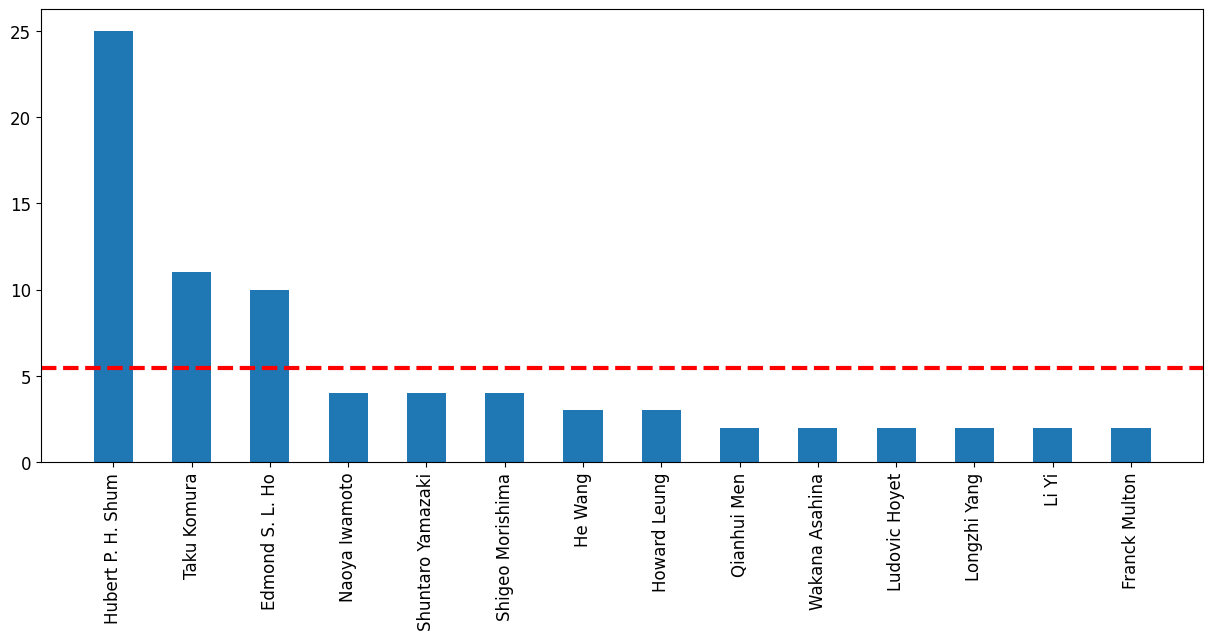

None


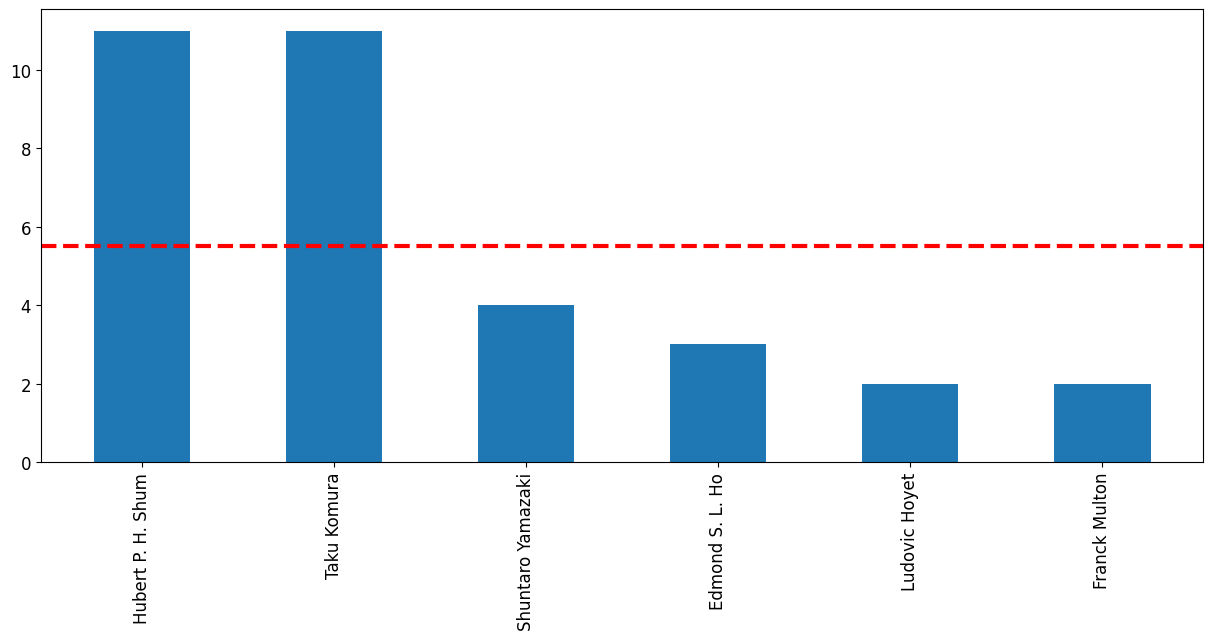

None


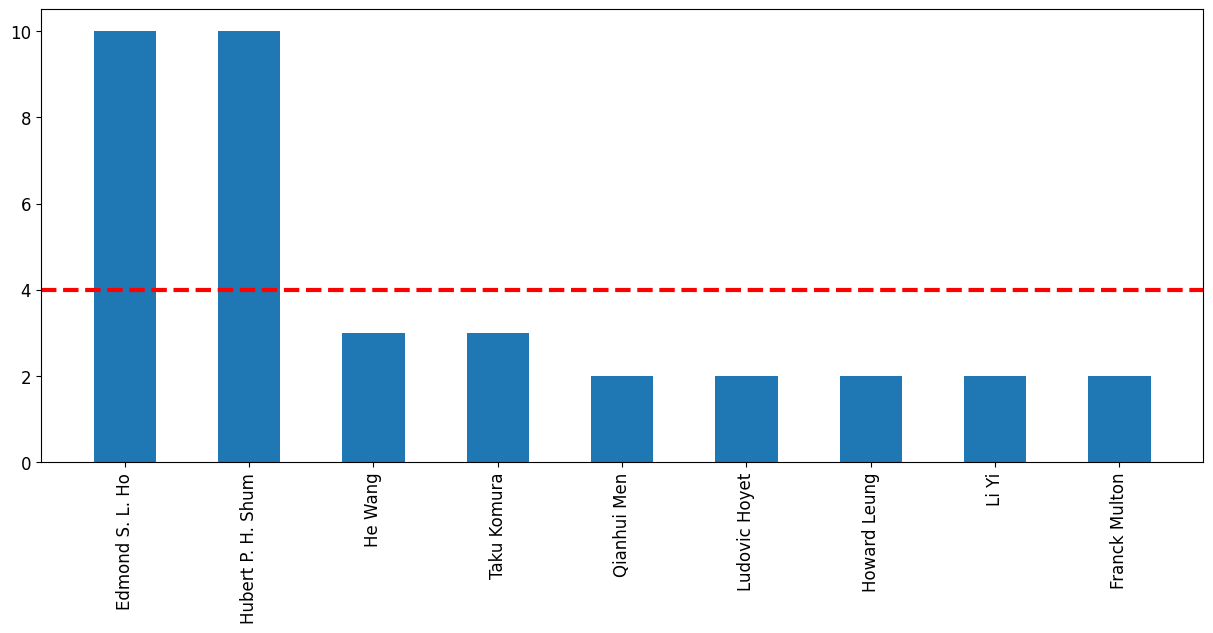

None


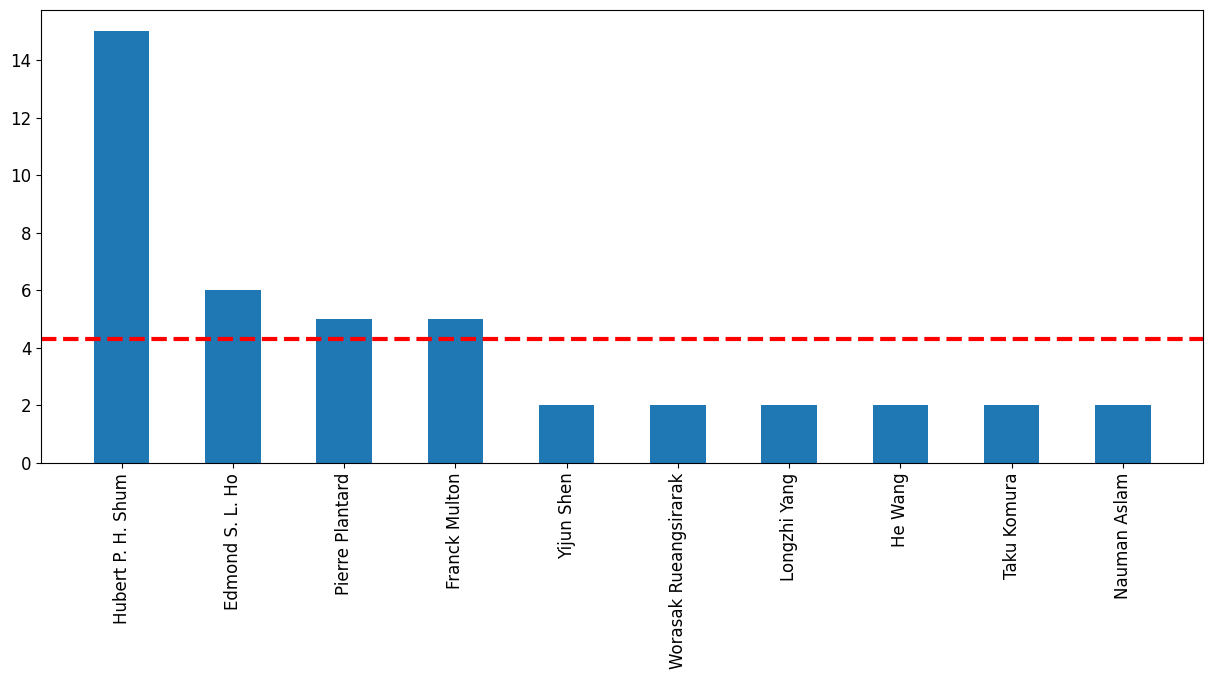

None


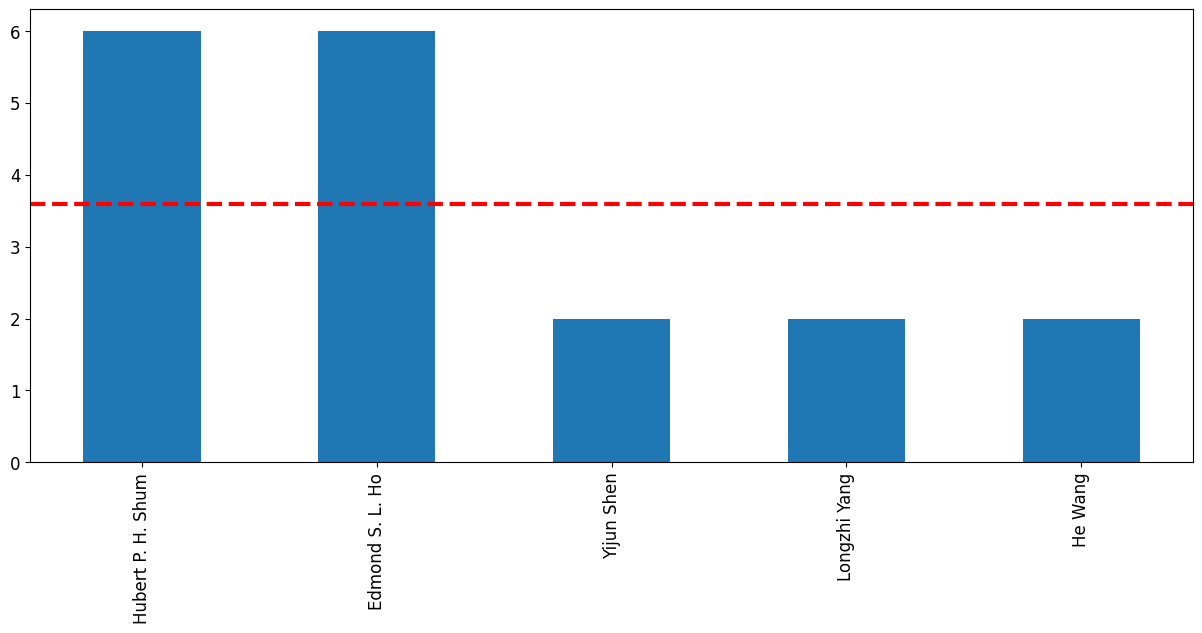

None


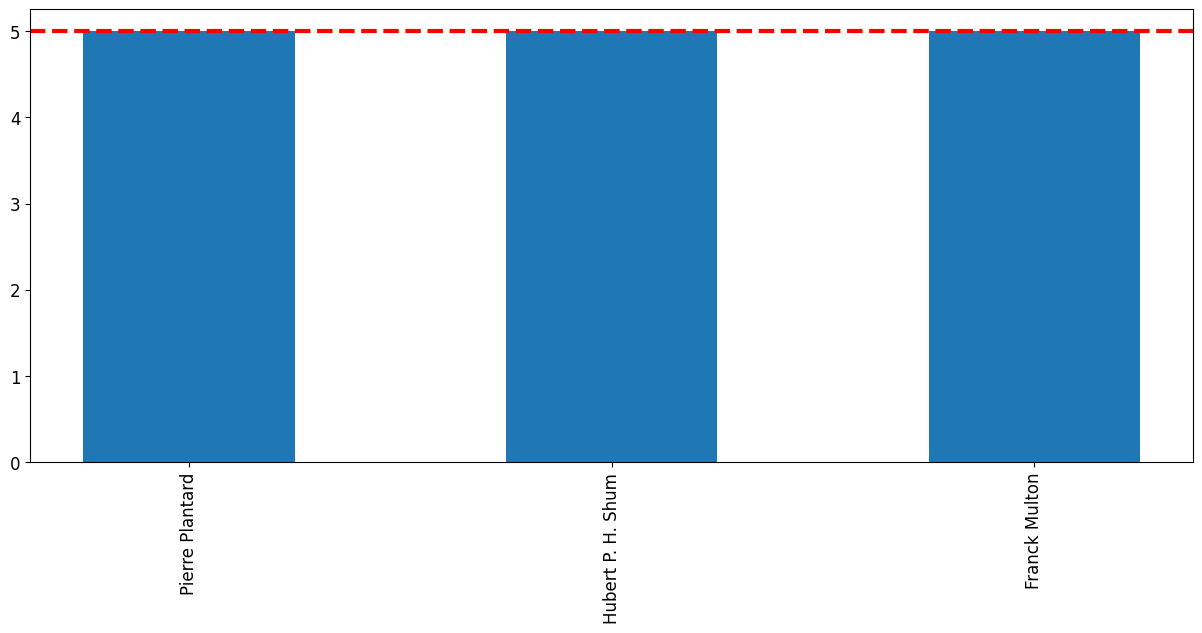

None


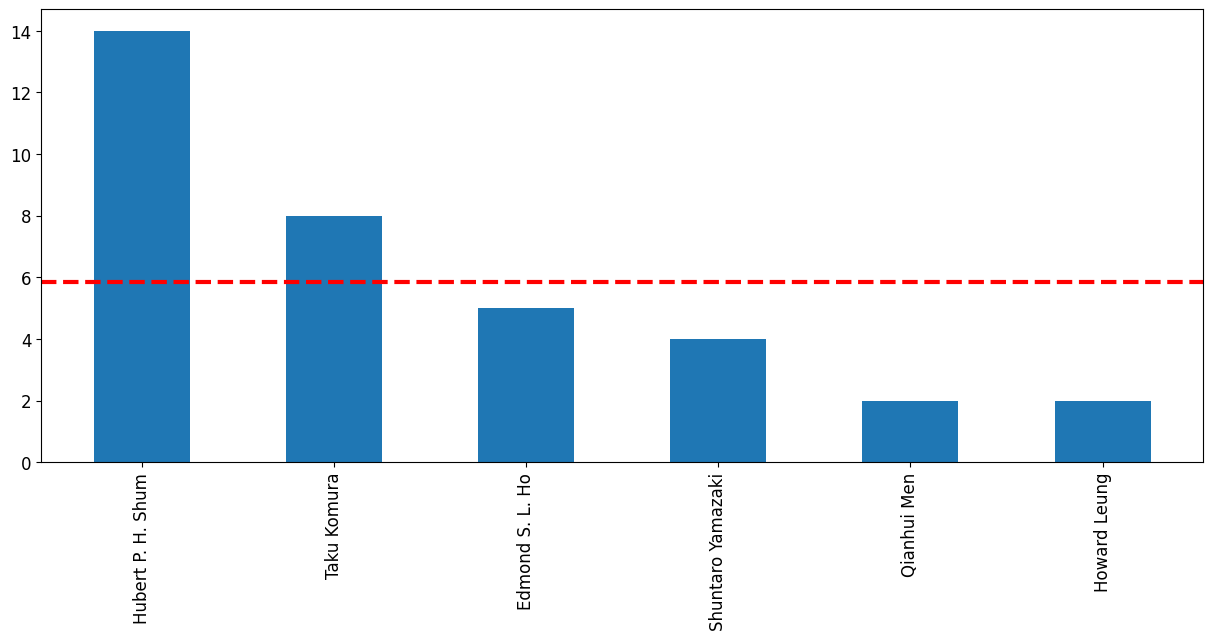

None


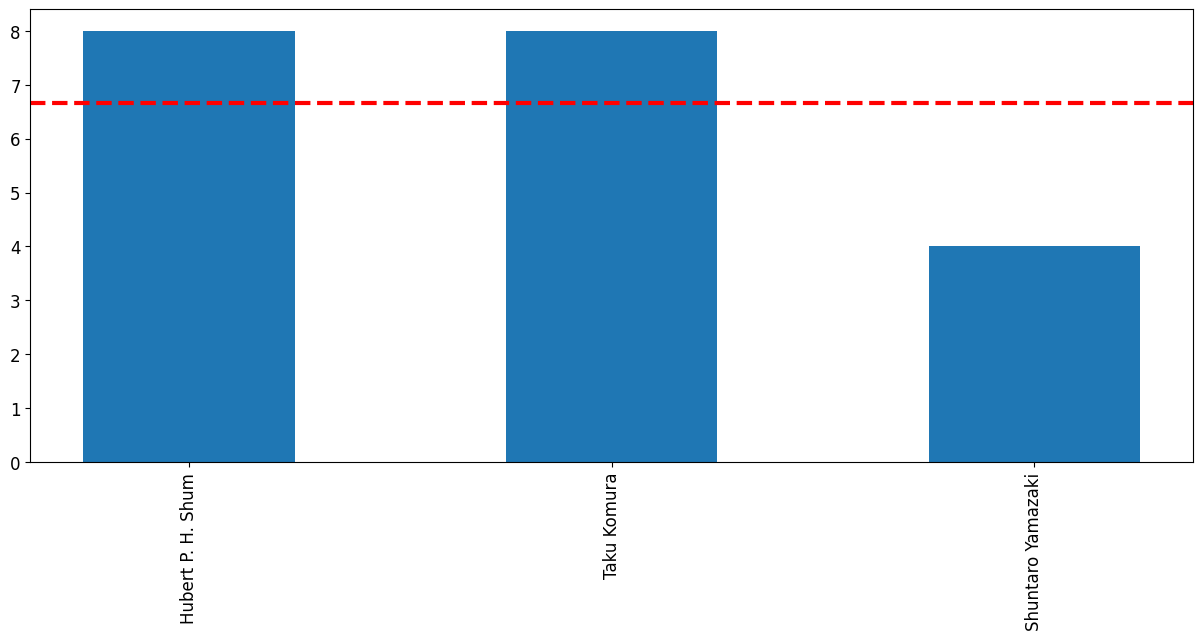

None


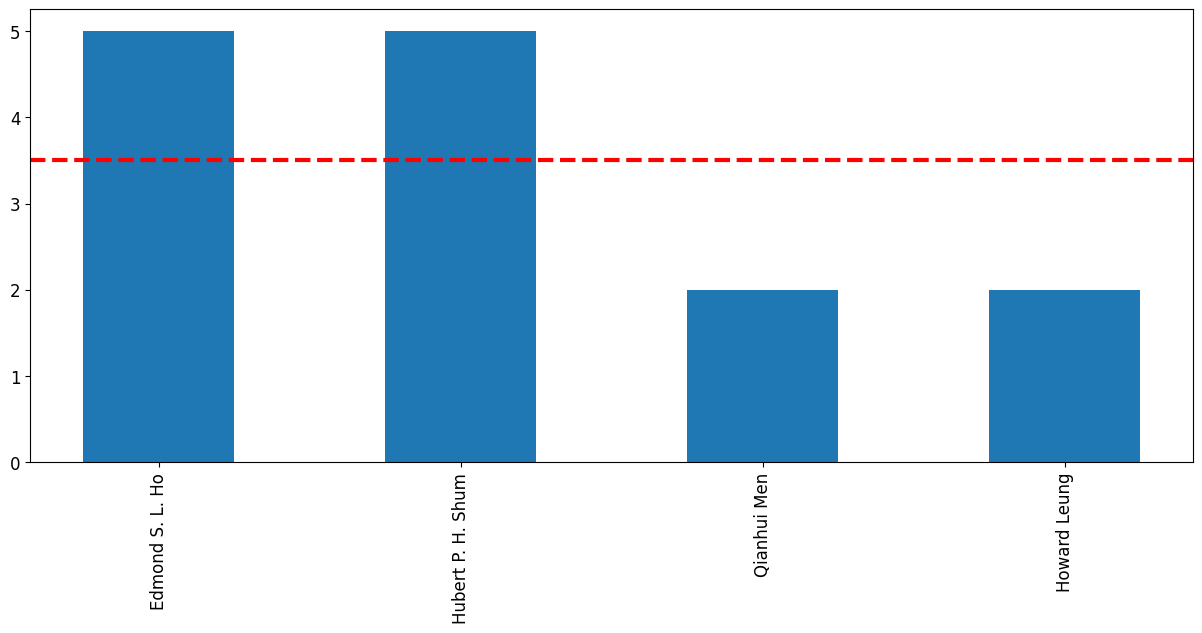

None


In [ ]:
def five_topic(topic):
    topic_l=topic.lower()
    topic_l=all_information[(all_information['1st topic']==topic) | (all_information['2nd topic']==topic)].iloc[:,4:11]
    return topic_l

def count_name(topic,name):
    data=five_topic(topic)
    rdata=data.loc[(data['lst author']==name)|(data['2nd author']==name)|(data['3rd author']==name)|(data['4th author']==name)|(data['5th author']==name)|(data['6th author']==name)|(data['7th author']==name)]
    name_list=[]
    for columns in rdata:
        for names in rdata[columns]:
            if names!=None:
                name_list.append(names)
    counts={}
    for item in name_list:
        counts[item] = counts.get(item, 0) + 1
        answer=sorted(counts.items(),key=lambda x:x[1],reverse=True)
    return answer
Character_Animation_Hubert_P_H_Shum=count_name('Character Animation','Hubert P. H. Shum')
Character_Animation_Taku_Komura=count_name('Character Animation','Taku Komura')
Character_Animation_Edmond_S_L_Ho=count_name('Character Animation','Edmond S. L. Ho')
Motion_Analysis_Hubert_P_H_Shum=count_name('Motion Analysis','Hubert P. H. Shum')
Motion_Analysis_Edmond_S_L_Ho=count_name('Motion Analysis','Edmond S. L. Ho')
Motion_Analysis_Pierre_Plantard=count_name('Motion Analysis','Pierre Plantard')
Interaction_Modelling_Hubert_P_H_Shum=count_name('Interaction Modelling','Hubert P. H. Shum')
Interaction_Modelling_Taku_Komura=count_name('Interaction Modelling','Taku Komura')
Interaction_Modelling_Edmond_S_L_Ho=count_name('Interaction Modelling','Edmond S. L. Ho')

# Draw ninth pictures about the author relationships
def graphs(topic_name):
    name=[]
    frequency=[]
    for fre in topic_name:
        if fre[1]>1:
            name.append(fre[0])
            frequency.append(fre[1])
    plt.figure(figsize=(15, 6), dpi=100)
    plt.rcParams['font.size'] = '12' 
    plt.xticks(rotation='vertical')
    plt.bar(name, frequency, width=0.5,tick_label=name)
    plt.axhline(y=np.mean(frequency),linewidth=3, ls='--', color='r')
    plt.show()

print(graphs(Character_Animation_Hubert_P_H_Shum))
print(graphs(Character_Animation_Taku_Komura))
print(graphs(Character_Animation_Edmond_S_L_Ho))
print(graphs(Motion_Analysis_Hubert_P_H_Shum))
print(graphs(Motion_Analysis_Edmond_S_L_Ho))
print(graphs(Motion_Analysis_Pierre_Plantard))
print(graphs(Interaction_Modelling_Hubert_P_H_Shum))
print(graphs(Interaction_Modelling_Taku_Komura))
print(graphs(Interaction_Modelling_Edmond_S_L_Ho))

In [ ]:
#Question 5 Please design and implement the solution to use data analysis and visualization for analysing how the features of a publication would affect its “citation” (a value that can be found in the publication detail pages).
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix as skm
# Gather the data of first topic, first and the scecond authors, journal names as the explaintory variables, while leaving citation as the output
# Get rid of the missing data
selected_frame=pd.concat([all_information.iloc[:,1],all_information.iloc[:,4:6],all_information.iloc[:,13],all_information.iloc[:,15]], axis=1).dropna(subset=['citation'])
selected_frame['citation']=selected_frame['citation'].astype(int)
selected_frame=selected_frame[selected_frame['citation']<=125]
selected_frame.reset_index(drop=True, inplace=True)
# Because the maximum of citation value is 125 and the minimum is above 0, it is recommend to split it into five categories
# mapping out the numeric data into categorial data
def number_change(number):
    if number<= 25:
        return 'Very Bad'
    elif (number>25) & (number<=50):
        return 'Slightly Bad'
    elif (number>50) & (number<=75):
        return 'Normal'
    elif (number>75) & (number<=100):
        return 'Slightly Good'
    else:
        return 'Very Good'
selected_frame['citation'] = selected_frame['citation'].map(number_change)
# Change every catergorical variables into dummy variables
selected_frame=pd.get_dummies(selected_frame)
X=selected_frame.iloc[:,0:163]
Y=selected_frame.iloc[:,163:168]
x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.75,test_size=0.25)

In [ ]:
# Because the the best n_nerighour numbers is around the root of sample size

neighour_number=math.sqrt(len(selected_frame))
print(neighour_number)
neighours=[8,9,10,11]
test_score=[]
data_score=[]
for neighour in neighours:
    knn=KNeighborsClassifier(n_neighbors=neighour,weights='distance')
    model=knn.fit(x_train,y_train)
    print(neighour,model.score(x_test,y_test),cross_val_score(model,X,Y,cv=10).mean())

#choose neighour number at 10
knn=KNeighborsClassifier(n_neighbors=10,weights='distance')
model=knn.fit(x_train,y_train)
print(model.score(x_test,y_test),cross_val_score(model,X,Y,cv=10).mean())
confustion_matrix=skm(y_test.to_numpy().argmax(axis=1),model.predict(x_test).argmax(axis=1))
print(confustion_matrix)

confustion_matrix=np.insert(confustion_matrix,0,[0],axis=1)
confustion_matrix=np.insert(confustion_matrix,0,[0],axis=0)

confustion_matrix=pd.DataFrame(confustion_matrix,index=["Prediction_Normal", "Prediction_Slightly Bad",'Prediction_Slightly Good','Prediction_Very Bad','Prediction_Very Good'],columns=["Observed_Normal", "Observed_Slightly Bad",'Observed_Slightly Good','Observed_Very Bad','Observed_Very Good'])
confustion_matrix
#If it doesn't work, ship this part to the next chunk of code because this part is random-generated

9.433981132056603
8 0.6521739130434783 0.7180555555555556
9 0.7391304347826086 0.7416666666666666
10 0.7391304347826086 0.7416666666666666
11 0.7391304347826086 0.7305555555555555
0.7391304347826086 0.7416666666666666
[[ 0  0  0  0]
 [ 0  0  0  2]
 [ 0  0  0  1]
 [ 3  0  0 17]]


,Observed_Normal,Observed_Slightly Bad,Observed_Slightly Good,Observed_Very Bad,Observed_Very Good
Prediction_Normal,0,0,0,0,0
Prediction_Slightly Bad,0,0,0,0,0
Prediction_Slightly Good,0,0,0,0,2
Prediction_Very Bad,0,0,0,0,1
Prediction_Very Good,0,3,0,0,17


In [ ]:
y_test.to_numpy()

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [ ]:
selected_frame=pd.concat([all_information.iloc[:,1],all_information.iloc[:,4:6],all_information.iloc[:,13],all_information.iloc[:,15]], axis=1).dropna(subset=['citation'])
selected_frame['citation']=selected_frame['citation'].astype(int)
selected_frame.reset_index(drop=True, inplace=True)
# it is important to divide the citation sum in each class by its count, otherwise the higher citations will belong to the class has higher frequancy
topic=selected_frame.groupby('1st topic').apply(lambda x: x['citation'].sum()/len(x)).reset_index(name='citation').sort_values('citation',ascending=False)
#filter out the less frequent authors
_1st_author=selected_frame.groupby('lst author').apply(lambda x:None if len(x)==1 else x['citation'].sum()/len(x)).reset_index(name='citation').sort_values('citation',ascending=False)
_2nd_author=selected_frame.groupby('2nd author').apply(lambda x:None if len(x)==1 else x['citation'].sum()/len(x)).reset_index(name='citation').sort_values('citation',ascending=False)
journal=selected_frame.groupby('journal').apply(lambda x: x['citation'].sum()/len(x)).reset_index(name='citation').sort_values('citation',ascending=False)

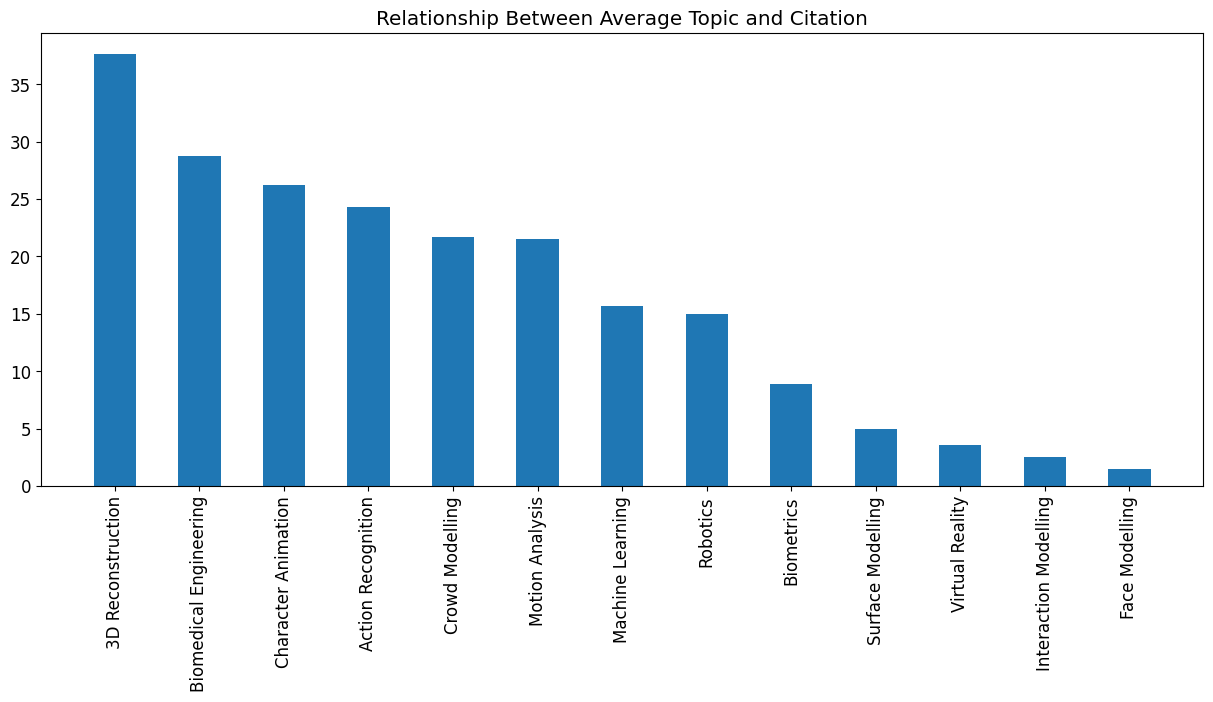

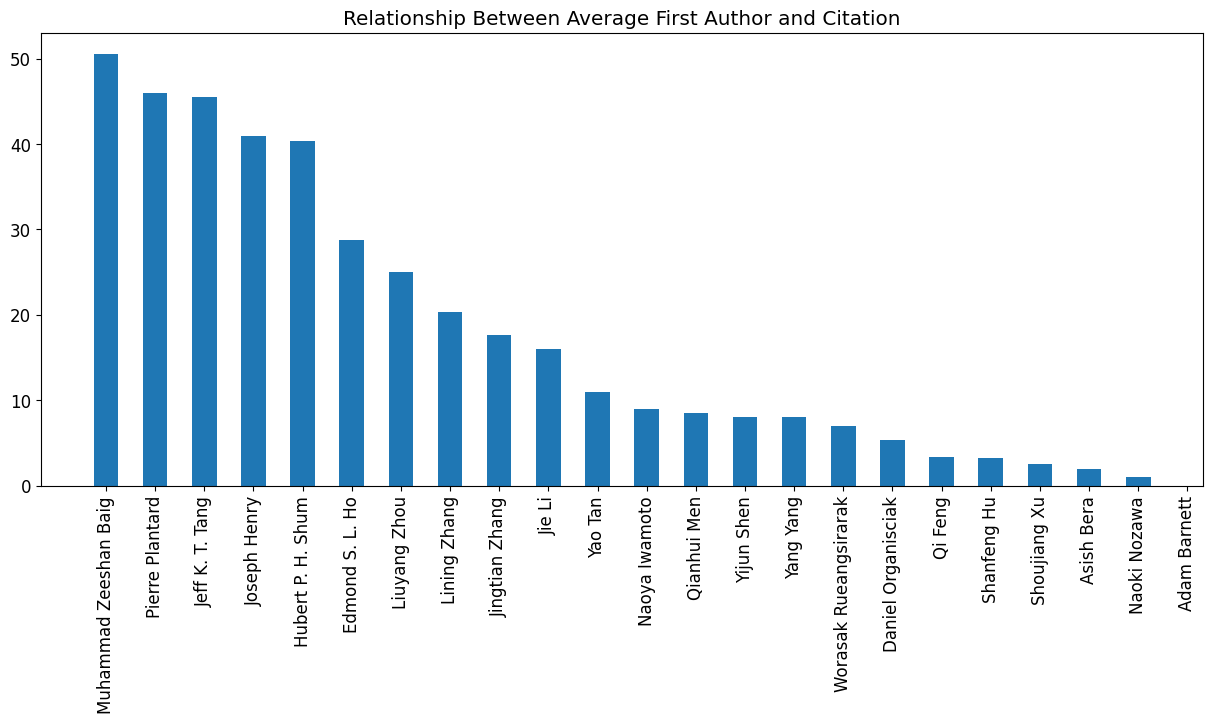

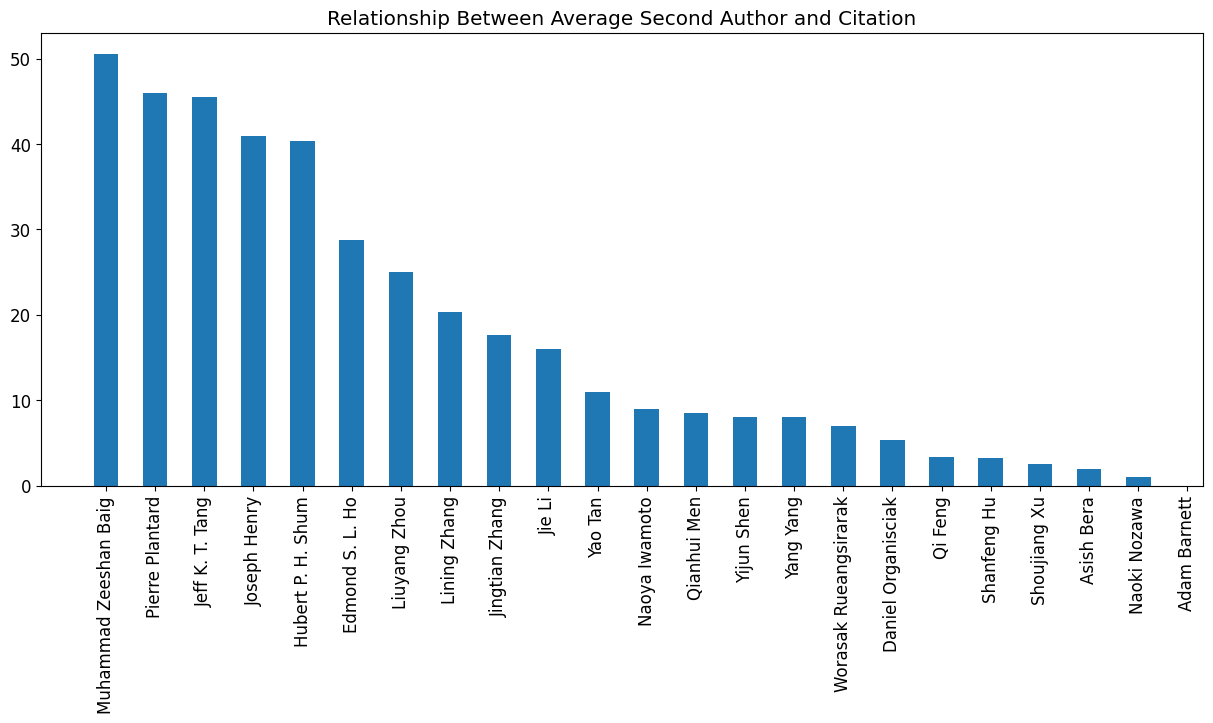

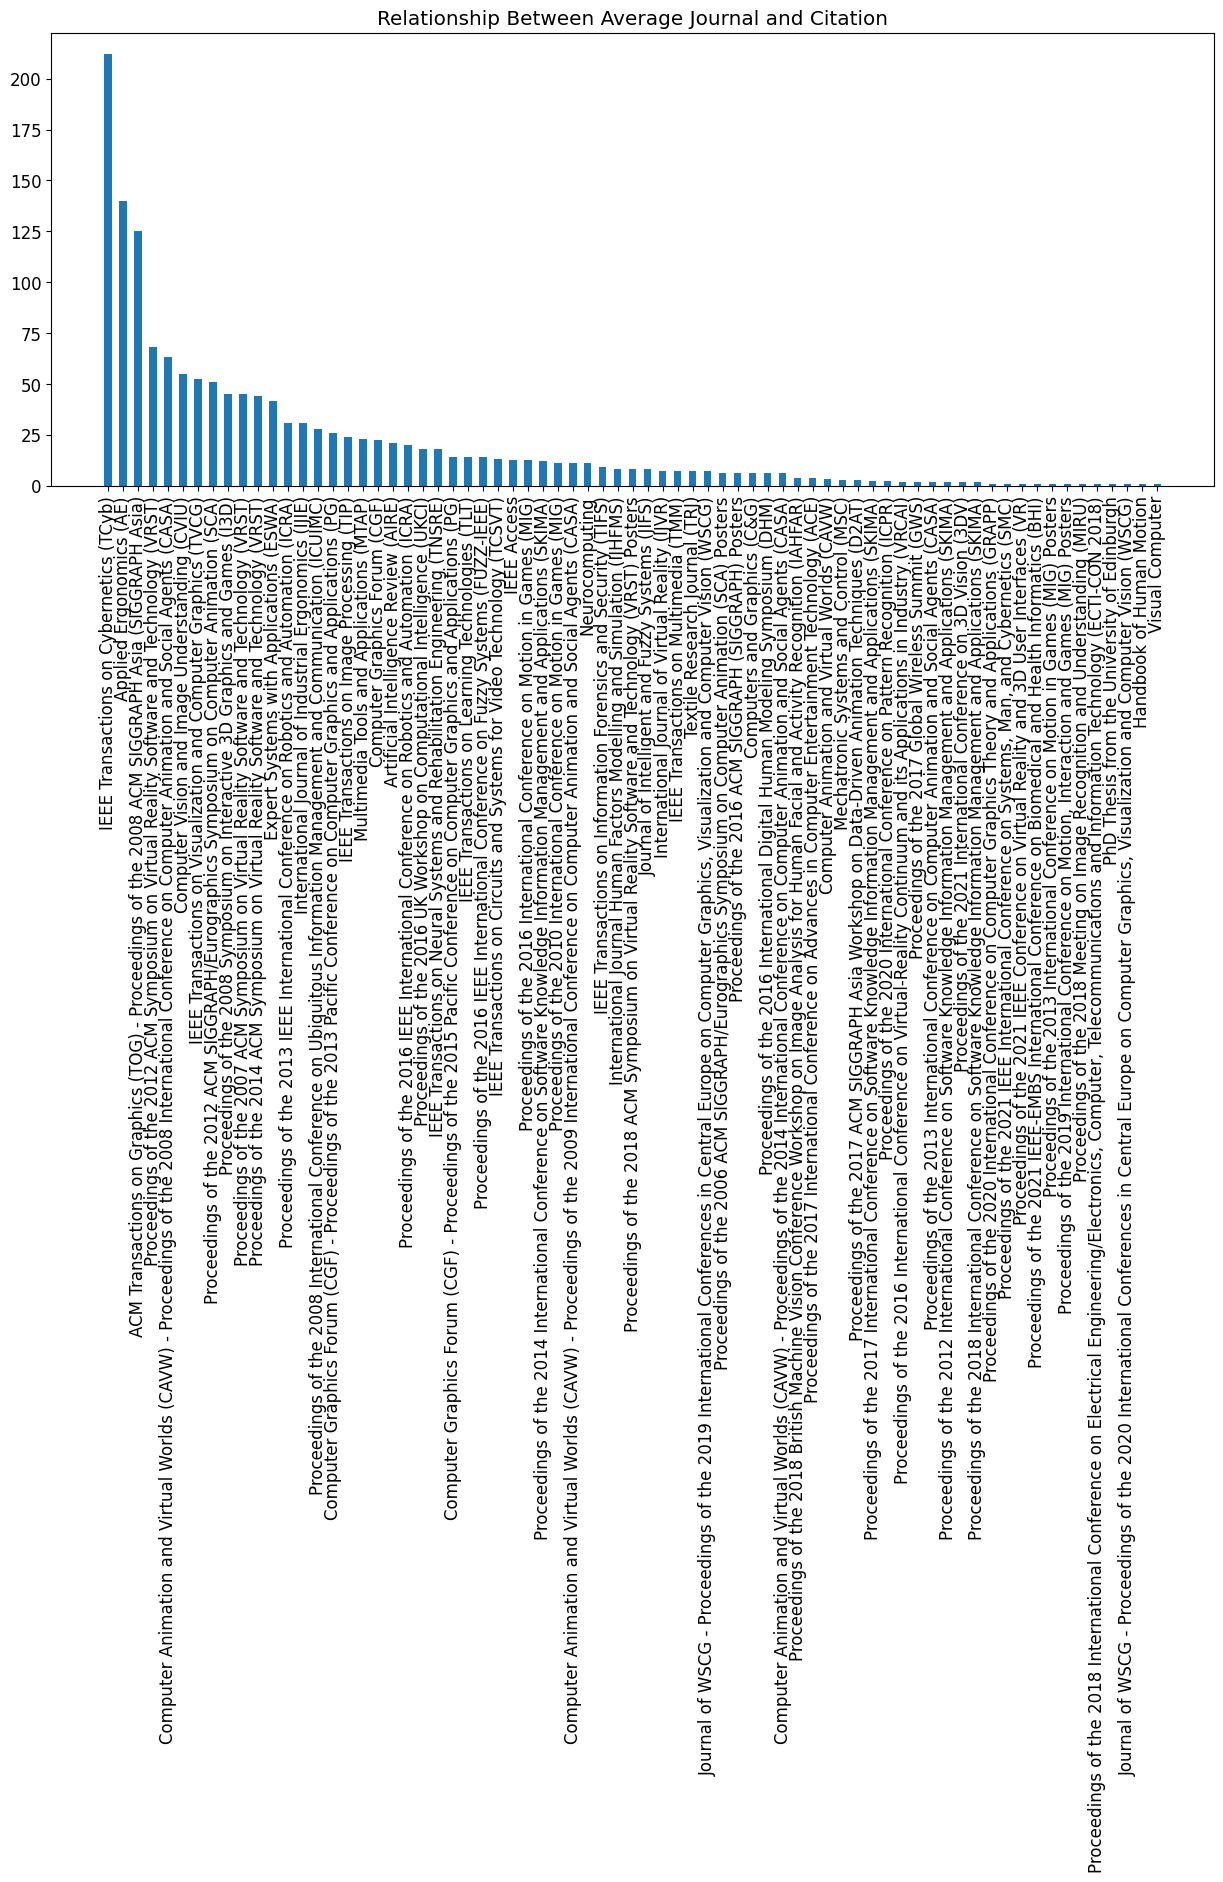

In [ ]:
#Draw the graphs of the relationship betwwen average feature and the citation

def painting_graphs():
    names=['Topic','First Author','Second Author','Journal']
    funs=[topic,_1st_author,_1st_author,journal]
    for name, fun in zip(names,funs):
        plt.figure(figsize=(15, 6), dpi=100)
        plt.rcParams['font.size'] = '12' 
        plt.xticks(rotation='vertical')
        plt.title('Relationship Between Average '+name+' and Citation')
        plt.bar(fun.iloc[:,0],fun.iloc[:,1],width=0.5)
        plt.show()

painting_graphs()